# ===========================================================
# Full pipeline for the influence matrix estimation problem on the supervised dataset from the Jeopardy-like logs for comparison on different models
# ===========================================================

Goals:
1. Split the data into test and train, and validation for multiple runs
2. Formulate all different models of convex optimization, neural networks, and tower models.
3. Give the same splits to all models, tune the hyperparameters with validation set, and report train and test erros as a pickle, a table, and a figure

#### Started on: 30 Dec 2019
#### Last update: 07 Jan 2020

# Imports

In [3]:
from __future__ import division, print_function, absolute_import, unicode_literals

import imp
import sys
import scipy as sp
import cvxpy as cp
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, LSTM, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Concatenate, Reshape, Embedding, Dot
from tensorflow.keras.models import Model
sys.path.insert(0, '../src/')
%matplotlib inline

import utils
import mytools
from estimation_lib import *
from mytools import Timer
from mytools import Tee

/home/omid/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/omid/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Parameters

In [11]:
DATA_FILE_PATH = '/home/omid/Datasets/Jeopardy/supervised_data_Feb05.pk'
# DATA_FILE_PATH = '/home/omid/Datasets/Jeopardy/supervised_data_roberta.pk'
TEST_FRACTION = 0.2
RUNS = 10

LAMBDAS = [0, 0.1, 1, 10, 100, 1000]
WITH_REPLICATION = True
ERROR_TYPE_STRS = ['mse', 'l1']  # 'normalized_frob_norm', 'neg_corr', 'cosine_dist']
TUNE_HYPERPARAMETERS_BY_VALIDATION = True
SELECTED_MODEL_FUNCS = ['average', 'uniform', 'random', last_model_func, sbt_model_func, mei_inspired_model_func, convex_optimization_model_func, concatinated_deep_neural_network_model_func]
# FEATURE_NAMES_SET = [['previous_influence_matrix', 'individual_performance'], ['previous_influence_matrix', 'individual_performance', 'reply_duration'], ['previous_influence_matrix', 'individual_performance', 'reply_duration', 'sentiment'], ['previous_influence_matrix', 'individual_performance', 'reply_duration', 'sentiment', 'average_of_previous_influence_matrices']]
FEATURE_NAMES_SET = [['previous_influence_matrix'], ['previous_influence_matrix', 'individual_performance'], ['individual_performance'], ['first_influence_matrix'], ['reply_duration'], ['sentiment'], ['average_of_previous_influence_matrices'], ['first_influence_matrix', 'individual_performance'], ['first_influence_matrix', 'individual_performance', 'reply_duration'], ['first_influence_matrix', 'individual_performance', 'reply_duration', 'emotion_dominance'], ['first_influence_matrix', 'individual_performance', 'reply_duration', 'emotion_dominance', 'average_of_previous_influence_matrices']]  # ['content_embedding_matrix'],
ESTIMATION_NAME = 'influence_matrix'  # 'most_influentials'

TO_WRITE_LOGS_ON_FILE = True

# Helper functions 

In [5]:
def reload():
    imp.reload(utils)
    imp.reload(mytools)

In [24]:
def plot_all_result_from_errors_in_runs(errors_in_runs):
    for error_type_str, features_dt in errors_in_runs.items():
        all_feature_set = sorted(features_dt.keys(), reverse=True)
        for feature_set in all_feature_set:
            models_dt = features_dt[feature_set]
            this_error_dt = []
            for model_str, errors in models_dt.items():
                if model_str == 'concatinated_deep_neural_network_model_func':
                    model_str = 'NN'
                elif model_str == 'convex_optimization_model_func':
                    model_str = 'convex'
                e = '{:.4f} $\pm$ {:.4f}'.format(np.mean(errors), np.std(errors))
                if model_str == 'last_model_func':
                    continue  # Ignores the last_model_func model.
                for err in errors:
                    this_error_dt.append([model_str, err])
            df = pd.DataFrame(this_error_dt, columns=['Model', 'Error'])
            sns.boxplot(x='Model', y='Error', data=df)
            plt.title('{} and {}'.format(error_type_str, feature_set))
            plt.show()
            print('\n')
            
            
def get_errors_in_table(errors_in_runs, ONLY_FOR_THIS_ERROR_TYPE_STR='mse'):
    order_of_models = np.array(
        ['random',
         'uniform',
         'average',
         'last_model_func',
         'sbt_model_func',
         'mei_inspired_model_func',
         'convex_optimization_model_func',
         'concatinated_deep_neural_network_model_func'])
    all_errors_dt = []
    features_dt = errors_in_runs[ONLY_FOR_THIS_ERROR_TYPE_STR]
    all_feature_set = sorted(features_dt.keys(), key=len)   # sorted(features_dt.keys(), reverse=True)
    for feature_set in all_feature_set:
        models_dt = features_dt[feature_set]
        errs = ['' for _ in range(len(order_of_models))]
        for model_str, errors in models_dt.items():
            e = '{:.4f} $\pm$ {:.4f}'.format(np.mean(errors), np.std(errors))
            errs[np.where(order_of_models == model_str)[0][0]] = e
        all_errors_dt.append([feature_set] + errs)
    return pd.DataFrame(all_errors_dt, columns=['Features'] + list(order_of_models))

# Loading the data

In [7]:
data = utils.load_it(DATA_FILE_PATH)
print(len(data['X']))

264


# Main body

## Estimation comparison pipeline

In [ ]:
if TO_WRITE_LOGS_ON_FILE:
    f = open('Outputs/output_run_at{}.txt'.format(str(datetime.now())), 'w')
    sys.stdout = Tee(sys.stdout, f)


with Timer():
    train_errors_in_runs = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    test_errors_in_runs = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    validation_errors_in_runs = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    for run in range(RUNS):
        print('Run', run + 1, '=>>>')
        X_train, X_test, y_train, y_test = train_test_split(
            np.array(data['X']), np.array(data['y']), test_size=TEST_FRACTION)
        for feature_names in FEATURE_NAMES_SET:
            print('\tFeatures: ', feature_names, '...')
            for selected_model_func in SELECTED_MODEL_FUNCS:
                if isinstance(selected_model_func, str):
                    selected_model_func_str = selected_model_func
                else:
                    selected_model_func_str = selected_model_func.__name__
                print('\t\tModel: ', selected_model_func_str, '...')
                for error_type_str in ERROR_TYPE_STRS:
                    print('\t\t\tError type: ', error_type_str)
                    train_error = 0
                    test_error = 0
                    validation_errors = 0
                    try:
                        train_error, test_error, validation_errors = model_builder(
                            X_train=X_train,
                            y_train=y_train,
                            X_test=X_test,
                            y_test=y_test,
                            feature_names=feature_names,
                            estimation_name=ESTIMATION_NAME,
                            error_type_str=error_type_str,
                            tune_hyperparameters_by_validation=TUNE_HYPERPARAMETERS_BY_VALIDATION,
                            with_replication=WITH_REPLICATION,
                            lambdas=LAMBDAS,
                            model_func=selected_model_func,
                            params={'with_constraints': True, 'n_splits': 3, 'n_epochs': 10, 'batch_size': 32, 'mode': 1})
                    except Exception as e:
                        print('An exception was raised:')
                        print(type(e.args))
                        print(e)
                        print('\n')
                        continue
                    key_str = error_type_str + ':' + str(feature_names) + ':' + selected_model_func_str
                    train_errors_in_runs[error_type_str][str(feature_names)][selected_model_func_str].append(
                        train_error)
                    test_errors_in_runs[error_type_str][str(feature_names)][selected_model_func_str].append(
                        test_error)
                    validation_errors_in_runs[error_type_str][str(feature_names)][selected_model_func_str].append(
                        validation_errors)
        utils.save_it(
            obj=train_errors_in_runs,
            file_path='Outputs/train_errors_newer_{}.pkl'.format(run+1),
            verbose=True)
        utils.save_it(
            obj=test_errors_in_runs,
            file_path='Outputs/test_errors_newer_{}.pkl'.format(run+1),
            verbose=True)
        utils.save_it(
            obj=validation_errors_in_runs,
            file_path='Outputs/validation_errors_newer_{}.pkl'.format(run+1),
            verbose=True)
    print('ALL DONE SUCCESSFULLY.')

Run 1 =>>>
	Features:  ['individual_performance'] ...
		Model:  average ...
			Error type:  mse
			Error type:  l1
		Model:  uniform ...
			Error type:  mse
			Error type:  l1
		Model:  random ...
			Error type:  mse
			Error type:  l1
		Model:  last_model_func ...
			Error type:  mse
3-fold validation ...
Replicating ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Replicating ...
Shapes of train: (3384,), validation: (70,), test: (53,).
Replicating ...
Shapes of train: (3384,), validation: (70,), test: (53,).
Training with the best lambda: 0 on entire training set...
Replicating ...
			Error type:  l1
3-fold validation ...
Replicating ...
Shapes of train: (3360,), validation: (71,), test: (53,).
Replicating ...
Shapes of train: (3384,), validation: (70,), test: (53,).
Replicating ...
Shapes of train: (3384,), validation: (70,), test: (53,).
Training with the best lambda: 0 on entire training set...
Replicating ...
		Model:  sbt_model_func ...
			Error type:  mse
3-fold v

3360/3360 [==============================] - ETA: 0s - loss: 75.8131 - accuracy: 0.062 - ETA: 0s - loss: 69.2033 - accuracy: 0.122 - ETA: 0s - loss: 64.3964 - accuracy: 0.112 - 0s 39us/sample - loss: 62.4333 - accuracy: 0.1119
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 52.4174 - accuracy: 0.093 - ETA: 0s - loss: 50.1435 - accuracy: 0.119 - ETA: 0s - loss: 48.2285 - accuracy: 0.111 - 0s 39us/sample - loss: 47.3110 - accuracy: 0.1119
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 42.9469 - accuracy: 0.031 - ETA: 0s - loss: 41.6961 - accuracy: 0.112 - ETA: 0s - loss: 40.4034 - accuracy: 0.111 - 0s 38us/sample - loss: 39.8374 - accuracy: 0.1119
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 36.7086 - accuracy: 0.093 - ETA: 0s - loss: 35.7934 - accuracy: 0.110 - ETA: 0s - loss: 34.8915 - accuracy: 0.115 - 0s 38us/sample - loss: 34.4755 - accuracy: 0.1119
Epoch 9/10
3360/3360 [==============================] - ETA

Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 27538.9629 - accuracy: 0.12 - ETA: 0s - loss: 26189.5588 - accuracy: 0.09 - ETA: 0s - loss: 25111.1068 - accuracy: 0.09 - 0s 39us/sample - loss: 24592.8734 - accuracy: 0.0982
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 21855.8535 - accuracy: 0.15 - ETA: 0s - loss: 21158.8387 - accuracy: 0.09 - ETA: 0s - loss: 20401.7357 - accuracy: 0.09 - 0s 41us/sample - loss: 19919.6836 - accuracy: 0.0982
Epoch 9/10
3360/3360 [==============================] - ETA: 0s - loss: 18246.5645 - accuracy: 0.06 - ETA: 0s - loss: 17314.5910 - accuracy: 0.11 - ETA: 0s - loss: 16633.4013 - accuracy: 0.09 - 0s 39us/sample - loss: 16296.2315 - accuracy: 0.0982
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 14637.0176 - accuracy: 0.09 - ETA: 0s - loss: 14097.4916 - accuracy: 0.09 - ETA: 0s - loss: 13525.1232 - accuracy: 0.09 - 0s 39us/sample - loss: 13258.8738 - accuracy: 0.0982
Replicating

Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 29.1931 - accuracy: 0.218 - ETA: 0s - loss: 28.5462 - accuracy: 0.114 - ETA: 0s - loss: 27.8991 - accuracy: 0.117 - 0s 42us/sample - loss: 27.4606 - accuracy: 0.1223
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 25.5312 - accuracy: 0.218 - ETA: 0s - loss: 25.1232 - accuracy: 0.125 - ETA: 0s - loss: 24.5711 - accuracy: 0.124 - 0s 41us/sample - loss: 24.1993 - accuracy: 0.1223
Input size for the neural network was: 4
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:22 - loss: 9047.1016 - accuracy: 0.062 - ETA: 4s - loss: 8672.1813 - accuracy: 0.0521  - ETA: 1s - loss: 8249.4556 - accuracy: 0.054 - ETA: 0s - loss: 7781.1324 - accuracy: 0.056 - ETA: 0s - loss: 7262.8629 - accuracy: 0.056 - 1s 304us/sample - loss: 6875.3267 - accuracy: 0.0603
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 4921.2725 - accuracy: 0.0000e+0 - ETA: 0s - l

3384/3384 [==============================] - ETA: 0s - loss: 29.4155 - accuracy: 0.031 - ETA: 0s - loss: 28.8891 - accuracy: 0.134 - ETA: 0s - loss: 28.3884 - accuracy: 0.143 - ETA: 0s - loss: 27.9137 - accuracy: 0.144 - 0s 48us/sample - loss: 27.8782 - accuracy: 0.1436
Input size for the neural network was: 4
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:19 - loss: 9158.4561 - accuracy: 0.0000e+0 - ETA: 3s - loss: 8667.9601 - accuracy: 0.0511      - ETA: 1s - loss: 8081.2162 - accuracy: 0.042 - ETA: 0s - loss: 7472.0889 - accuracy: 0.052 - 1s 283us/sample - loss: 6915.6589 - accuracy: 0.0576
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 4923.4805 - accuracy: 0.062 - ETA: 0s - loss: 4427.3528 - accuracy: 0.059 - ETA: 0s - loss: 4008.9746 - accuracy: 0.063 - ETA: 0s - loss: 3594.1947 - accuracy: 0.066 - 0s 47us/sample - loss: 3575.5949 - accuracy: 0.0674
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - los

3360/3360 [==============================] - ETA: 0s - loss: 12.5637 - accuracy: 0.281 - ETA: 0s - loss: 12.5282 - accuracy: 0.185 - ETA: 0s - loss: 12.4717 - accuracy: 0.186 - 0s 38us/sample - loss: 12.4474 - accuracy: 0.1854
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 12.3161 - accuracy: 0.187 - ETA: 0s - loss: 12.2600 - accuracy: 0.162 - ETA: 0s - loss: 12.2093 - accuracy: 0.146 - 0s 38us/sample - loss: 12.1884 - accuracy: 0.1405
Input size for the neural network was: 4
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 56s - loss: 903.8424 - accuracy: 0.093 - ETA: 2s - loss: 857.4795 - accuracy: 0.046 - ETA: 0s - loss: 780.5047 - accuracy: 0.05 - ETA: 0s - loss: 724.8044 - accuracy: 0.05 - 1s 220us/sample - loss: 687.8336 - accuracy: 0.0557
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 495.9426 - accuracy: 0.0000e+ - ETA: 0s - loss: 445.3376 - accuracy: 0.0683   - ETA: 0s - loss: 397.2837 - accur

Input size for the neural network was: 4
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 57s - loss: 885094.7500 - accuracy: 0.15 - ETA: 2s - loss: 832757.7283 - accuracy: 0.0584 - ETA: 0s - loss: 777845.1081 - accuracy: 0.059 - ETA: 0s - loss: 719530.3839 - accuracy: 0.062 - 1s 225us/sample - loss: 667573.7979 - accuracy: 0.0643
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 475916.5938 - accuracy: 0.031 - ETA: 0s - loss: 439503.1422 - accuracy: 0.063 - ETA: 0s - loss: 390788.8965 - accuracy: 0.063 - ETA: 0s - loss: 350706.7694 - accuracy: 0.067 - 0s 47us/sample - loss: 348644.3768 - accuracy: 0.0682
Epoch 3/10
3360/3360 [==============================] - ETA: 0s - loss: 239711.2500 - accuracy: 0.031 - ETA: 0s - loss: 210028.9723 - accuracy: 0.085 - ETA: 0s - loss: 185569.3940 - accuracy: 0.095 - 0s 41us/sample - loss: 170551.8511 - accuracy: 0.0994
Epoch 4/10
3360/3360 [==============================] - ETA: 0s - loss: 11518

3384/3384 [==============================] - ETA: 0s - loss: 473510.1250 - accuracy: 0.062 - ETA: 0s - loss: 417979.4736 - accuracy: 0.070 - ETA: 0s - loss: 369999.7784 - accuracy: 0.076 - 0s 42us/sample - loss: 339957.9166 - accuracy: 0.0759
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 230776.7812 - accuracy: 0.125 - ETA: 0s - loss: 199956.1582 - accuracy: 0.094 - ETA: 0s - loss: 174997.8988 - accuracy: 0.116 - 0s 41us/sample - loss: 161837.0183 - accuracy: 0.1203
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 108207.5625 - accuracy: 0.250 - ETA: 0s - loss: 95767.3838 - accuracy: 0.133 - ETA: 0s - loss: 85104.0186 - accuracy: 0.13 - 0s 42us/sample - loss: 78657.8653 - accuracy: 0.1398
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 57135.9688 - accuracy: 0.18 - ETA: 0s - loss: 51489.8611 - accuracy: 0.15 - ETA: 0s - loss: 47276.5621 - accuracy: 0.14 - 0s 41us/sample - loss: 44941.1077 - accuracy: 0.1413
Epoch 

Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 267.4820 - accuracy: 0.09 - ETA: 0s - loss: 238.2426 - accuracy: 0.07 - ETA: 0s - loss: 213.3954 - accuracy: 0.09 - 0s 43us/sample - loss: 195.8399 - accuracy: 0.1040
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 139.7445 - accuracy: 0.12 - ETA: 0s - loss: 124.9330 - accuracy: 0.12 - ETA: 0s - loss: 113.4638 - accuracy: 0.13 - 0s 41us/sample - loss: 106.8587 - accuracy: 0.1333
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 82.5682 - accuracy: 0.156 - ETA: 0s - loss: 76.3587 - accuracy: 0.132 - ETA: 0s - loss: 71.6379 - accuracy: 0.133 - 0s 41us/sample - loss: 68.7589 - accuracy: 0.1327
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 57.8144 - accuracy: 0.218 - ETA: 0s - loss: 56.0827 - accuracy: 0.144 - ETA: 0s - loss: 54.1574 - accuracy: 0.136 - 0s 41us/sample - loss: 52.9425 - accuracy: 0.1436
Epoch 7/10
3384/3384 [========================

Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 68398.5703 - accuracy: 0.09 - ETA: 0s - loss: 62080.3175 - accuracy: 0.14 - ETA: 0s - loss: 56784.2242 - accuracy: 0.14 - 0s 41us/sample - loss: 53822.5564 - accuracy: 0.1430
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 42362.0664 - accuracy: 0.09 - ETA: 0s - loss: 39951.5497 - accuracy: 0.13 - ETA: 0s - loss: 37922.6291 - accuracy: 0.14 - 0s 41us/sample - loss: 36695.5305 - accuracy: 0.1436
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 31968.1328 - accuracy: 0.15 - ETA: 0s - loss: 30508.0823 - accuracy: 0.13 - ETA: 0s - loss: 29147.8075 - accuracy: 0.13 - 0s 41us/sample - loss: 28197.1214 - accuracy: 0.1436
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 25145.0059 - accuracy: 0.15 - ETA: 0s - loss: 23731.2659 - accuracy: 0.13 - ETA: 0s - loss: 22738.3852 - accuracy: 0.14 - 0s 41us/sample - loss: 22104.4534 - accuracy: 0.1436
Epoch 9/10
3

Variables are:
	first_influence_matrix: (4, 4)
The status of solution was: optimal and the result was: 4471.743875151423
Replicating ...
Shapes of train: (3384,), validation: (70,), test: (53,).
Computing convex loss on 3384 training data samples.
Variables are:
	first_influence_matrix: (4, 4)
The status of solution was: optimal and the result was: 465.8793372684054
Computing convex loss on 3384 training data samples.
Variables are:
	first_influence_matrix: (4, 4)
The status of solution was: optimal and the result was: 466.2793357601141
Computing convex loss on 3384 training data samples.
Variables are:
	first_influence_matrix: (4, 4)
The status of solution was: optimal and the result was: 469.8793369761179
Computing convex loss on 3384 training data samples.
Variables are:
	first_influence_matrix: (4, 4)
The status of solution was: optimal and the result was: 505.87933674591034
Computing convex loss on 3384 training data samples.
Variables are:
	first_influence_matrix: (4, 4)
The stat

3360/3360 [==============================] - ETA: 0s - loss: 32.4524 - accuracy: 0.125 - ETA: 0s - loss: 29.6033 - accuracy: 0.185 - ETA: 0s - loss: 26.9969 - accuracy: 0.186 - 0s 43us/sample - loss: 25.2968 - accuracy: 0.1807
Epoch 10/10
3360/3360 [==============================] - ETA: 0s - loss: 19.8026 - accuracy: 0.187 - ETA: 0s - loss: 18.7139 - accuracy: 0.148 - ETA: 0s - loss: 18.0309 - accuracy: 0.166 - 0s 40us/sample - loss: 17.7550 - accuracy: 0.1536
Input size for the neural network was: 16
Train on 3360 samples
Epoch 1/10
3360/3360 [==============================] - ETA: 1:08 - loss: 91637.6562 - accuracy: 0.0000e+ - ETA: 2s - loss: 85202.3287 - accuracy: 0.0556     - ETA: 0s - loss: 78626.3288 - accuracy: 0.05 - ETA: 0s - loss: 71995.2121 - accuracy: 0.05 - 1s 251us/sample - loss: 68728.6575 - accuracy: 0.0601
Epoch 2/10
3360/3360 [==============================] - ETA: 0s - loss: 49056.9922 - accuracy: 0.06 - ETA: 0s - loss: 43434.7266 - accuracy: 0.06 - ETA: 0s - loss: 

Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 3:01 - loss: 106.2376 - accuracy: 0.0000e+ - ETA: 6s - loss: 100.5708 - accuracy: 0.0378     - ETA: 2s - loss: 95.3572 - accuracy: 0.0428 - ETA: 0s - loss: 89.0070 - accuracy: 0.051 - 2s 571us/sample - loss: 82.8276 - accuracy: 0.0606
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 62.3480 - accuracy: 0.031 - ETA: 0s - loss: 56.9472 - accuracy: 0.092 - ETA: 0s - loss: 52.0308 - accuracy: 0.106 - 0s 44us/sample - loss: 48.3016 - accuracy: 0.1114
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 36.4028 - accuracy: 0.187 - ETA: 0s - loss: 33.1831 - accuracy: 0.129 - ETA: 0s - loss: 30.4001 - accuracy: 0.134 - 0s 43us/sample - loss: 28.5671 - accuracy: 0.1389
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 22.2365 - accuracy: 0.218 - ETA: 0s - loss: 20.5910 - accuracy: 0.162 - ETA: 0s - loss: 19.3

3384/3384 [==============================] - ETA: 0s - loss: 35.8613 - accuracy: 0.093 - ETA: 0s - loss: 32.7977 - accuracy: 0.171 - ETA: 0s - loss: 30.1296 - accuracy: 0.173 - 0s 42us/sample - loss: 28.4223 - accuracy: 0.1708
Epoch 4/10
3384/3384 [==============================] - ETA: 0s - loss: 22.2012 - accuracy: 0.187 - ETA: 0s - loss: 20.6557 - accuracy: 0.125 - ETA: 0s - loss: 19.3498 - accuracy: 0.136 - 0s 42us/sample - loss: 18.5211 - accuracy: 0.1312
Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 15.6569 - accuracy: 0.062 - ETA: 0s - loss: 14.9962 - accuracy: 0.123 - ETA: 0s - loss: 14.4700 - accuracy: 0.127 - 0s 42us/sample - loss: 14.1213 - accuracy: 0.1271
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 12.9565 - accuracy: 0.156 - ETA: 0s - loss: 12.7482 - accuracy: 0.117 - ETA: 0s - loss: 12.5611 - accuracy: 0.124 - 0s 45us/sample - loss: 12.4164 - accuracy: 0.1271
Epoch 7/10
3384/3384 [==============================] - ETA

Epoch 5/10
3384/3384 [==============================] - ETA: 0s - loss: 4088.0366 - accuracy: 0.187 - ETA: 0s - loss: 3424.0842 - accuracy: 0.118 - ETA: 0s - loss: 2931.6846 - accuracy: 0.114 - 0s 41us/sample - loss: 2637.4892 - accuracy: 0.1135
Epoch 6/10
3384/3384 [==============================] - ETA: 0s - loss: 1590.8685 - accuracy: 0.093 - ETA: 0s - loss: 1390.0751 - accuracy: 0.129 - ETA: 0s - loss: 1233.7256 - accuracy: 0.118 - 0s 42us/sample - loss: 1138.7353 - accuracy: 0.1135
Epoch 7/10
3384/3384 [==============================] - ETA: 0s - loss: 813.4321 - accuracy: 0.09 - ETA: 0s - loss: 726.7512 - accuracy: 0.11 - ETA: 0s - loss: 657.0600 - accuracy: 0.11 - 0s 44us/sample - loss: 593.2212 - accuracy: 0.1135
Epoch 8/10
3384/3384 [==============================] - ETA: 0s - loss: 396.5397 - accuracy: 0.06 - ETA: 0s - loss: 348.4257 - accuracy: 0.11 - ETA: 0s - loss: 306.5217 - accuracy: 0.11 - 0s 42us/sample - loss: 277.9940 - accuracy: 0.1135
Epoch 9/10
3384/3384 [========

3360/3360 [==============================] - ETA: 0s - loss: 454.2831 - accuracy: 0.06 - ETA: 0s - loss: 387.2799 - accuracy: 0.13 - ETA: 0s - loss: 333.8884 - accuracy: 0.12 - 0s 40us/sample - loss: 306.1123 - accuracy: 0.1310
Epoch 6/10
3360/3360 [==============================] - ETA: 0s - loss: 191.9212 - accuracy: 0.18 - ETA: 0s - loss: 164.0657 - accuracy: 0.13 - ETA: 0s - loss: 144.0774 - accuracy: 0.13 - 0s 39us/sample - loss: 135.4186 - accuracy: 0.1310
Epoch 7/10
3360/3360 [==============================] - ETA: 0s - loss: 96.1150 - accuracy: 0.062 - ETA: 0s - loss: 85.2438 - accuracy: 0.123 - ETA: 0s - loss: 76.2859 - accuracy: 0.129 - 0s 39us/sample - loss: 71.7042 - accuracy: 0.1310
Epoch 8/10
3360/3360 [==============================] - ETA: 0s - loss: 51.5411 - accuracy: 0.187 - ETA: 0s - loss: 46.0317 - accuracy: 0.153 - ETA: 0s - loss: 41.1930 - accuracy: 0.163 - 0s 40us/sample - loss: 38.9701 - accuracy: 0.1560
Epoch 9/10
3360/3360 [==============================] - E

3384/3384 [==============================] - ETA: 0s - loss: 54.6840 - accuracy: 0.125 - ETA: 0s - loss: 50.1496 - accuracy: 0.115 - ETA: 0s - loss: 46.3447 - accuracy: 0.113 - 0s 42us/sample - loss: 43.7971 - accuracy: 0.1082
Epoch 9/10
3384/3384 [==============================] - ETA: 0s - loss: 34.6930 - accuracy: 0.125 - ETA: 0s - loss: 32.3604 - accuracy: 0.136 - ETA: 0s - loss: 30.1443 - accuracy: 0.159 - 0s 42us/sample - loss: 28.5907 - accuracy: 0.1557
Epoch 10/10
3384/3384 [==============================] - ETA: 0s - loss: 23.2919 - accuracy: 0.093 - ETA: 0s - loss: 21.9047 - accuracy: 0.103 - ETA: 0s - loss: 20.8278 - accuracy: 0.107 - 0s 42us/sample - loss: 20.1606 - accuracy: 0.1034
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:04 - loss: 92346.1250 - accuracy: 0.09 - ETA: 2s - loss: 87738.5863 - accuracy: 0.0699 - ETA: 1s - loss: 82863.8596 - accuracy: 0.07 - ETA: 0s - loss: 76970.0292 - accur

3384/3384 [==============================] - ETA: 0s - loss: 22.7798 - accuracy: 0.156 - ETA: 0s - loss: 21.4586 - accuracy: 0.166 - ETA: 0s - loss: 20.6084 - accuracy: 0.181 - 0s 42us/sample - loss: 20.0918 - accuracy: 0.1862
Input size for the neural network was: 16
Train on 3384 samples
Epoch 1/10
3384/3384 [==============================] - ETA: 1:09 - loss: 93639.3125 - accuracy: 0.06 - ETA: 2s - loss: 88386.5737 - accuracy: 0.0625 - ETA: 0s - loss: 82826.9323 - accuracy: 0.06 - ETA: 0s - loss: 76542.6264 - accuracy: 0.06 - ETA: 0s - loss: 70978.3592 - accuracy: 0.07 - 1s 259us/sample - loss: 70644.8145 - accuracy: 0.0691
Epoch 2/10
3384/3384 [==============================] - ETA: 0s - loss: 50260.0859 - accuracy: 0.06 - ETA: 0s - loss: 45244.9814 - accuracy: 0.08 - ETA: 0s - loss: 40183.3870 - accuracy: 0.09 - 0s 44us/sample - loss: 36347.0031 - accuracy: 0.1049
Epoch 3/10
3384/3384 [==============================] - ETA: 0s - loss: 24509.9180 - accuracy: 0.12 - ETA: 0s - loss: 

Computing convex loss on 3384 training data samples.
Variables are:
	reply_duration: (4, 4)


## Visualization of the results

In [8]:
train_errors3 = utils.load_it('Outputs/train_errors_newer_3.pkl.dill')
test_errors3 = utils.load_it('Outputs/test_errors_newer_3.pkl.dill')
validation_errors3 = utils.load_it('Outputs/validation_errors_newer_3.pkl.dill')

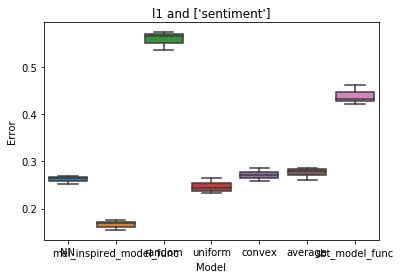

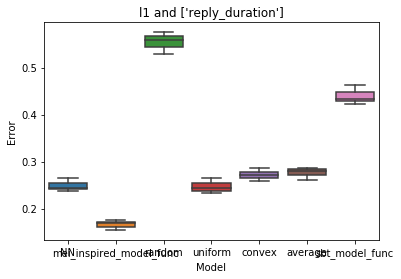

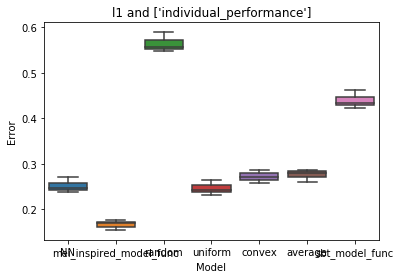

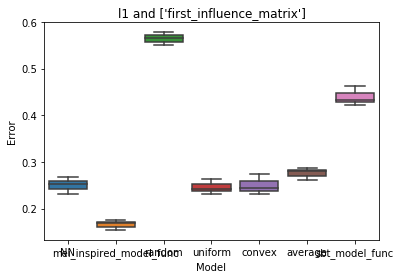

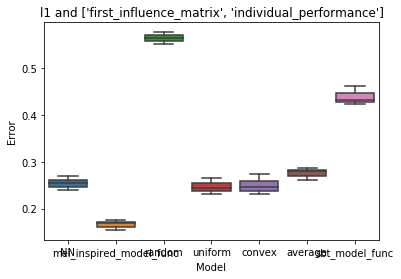

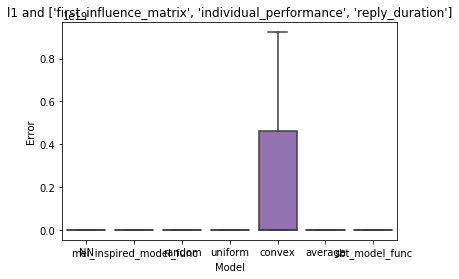

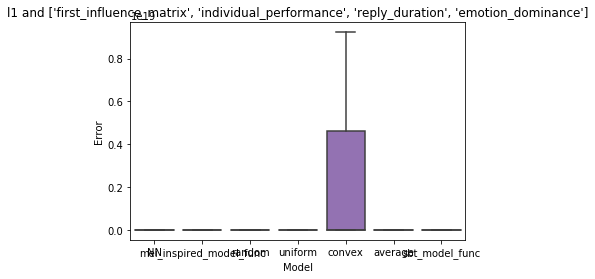

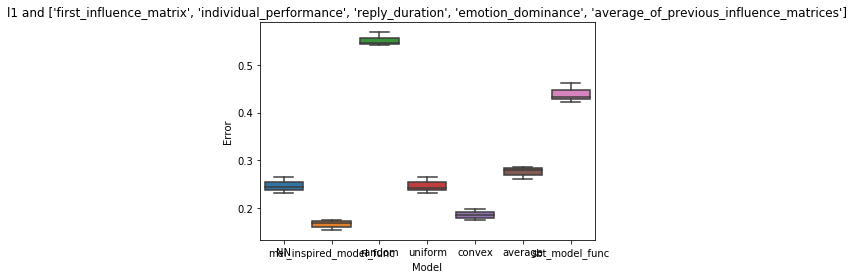

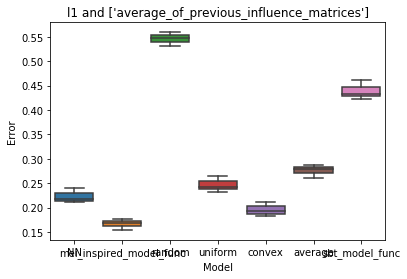

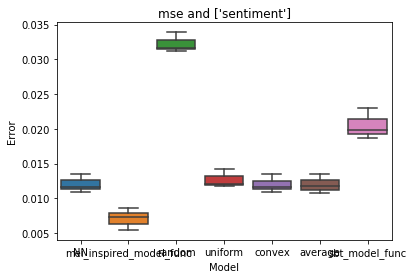

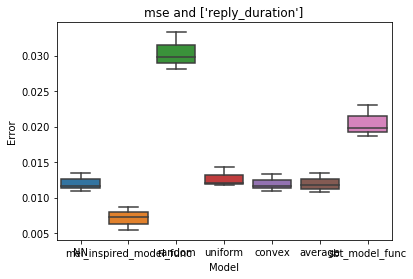

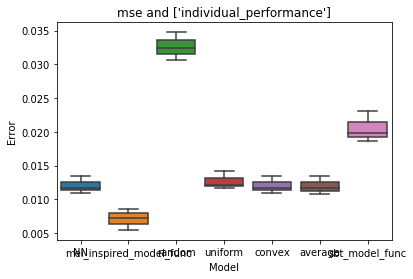

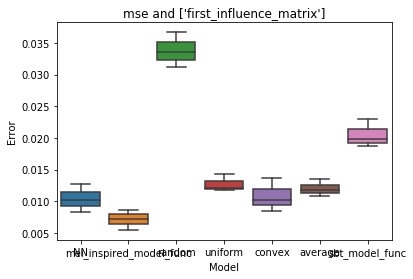

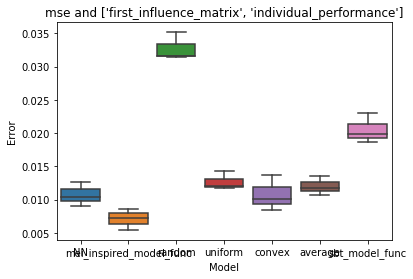

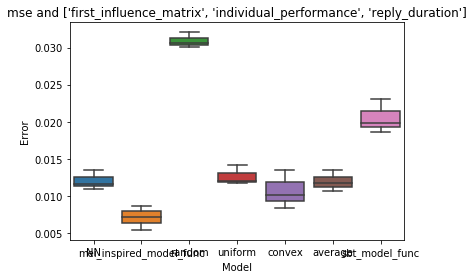

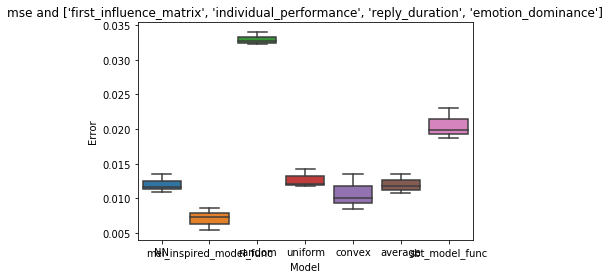

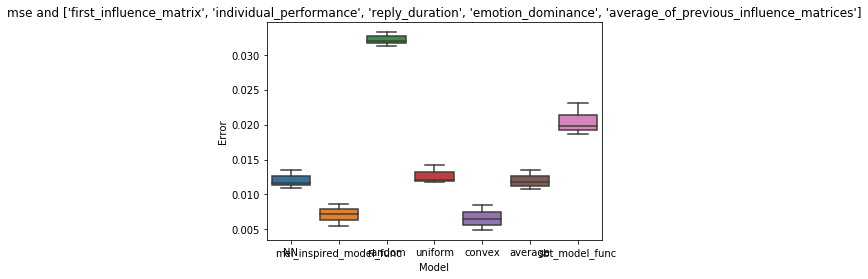

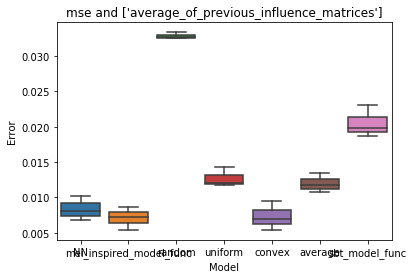

In [17]:
plot_all_result_from_errors_in_runs(test_errors3)

In [25]:
get_errors_in_table(test_errors3)

,Features,random,uniform,average,last_model_func,sbt_model_func,mei_inspired_model_func,convex_optimization_model_func,concatinated_deep_neural_network_model_func
0,['sentiment'],0.0323 $\pm$ 0.0012,0.0127 $\pm$ 0.0011,0.0120 $\pm$ 0.0011,0.0071 $\pm$ 0.0013,0.0205 $\pm$ 0.0018,0.0071 $\pm$ 0.0013,0.0120 $\pm$ 0.0011,0.0120 $\pm$ 0.0011
1,['reply_duration'],0.0304 $\pm$ 0.0021,0.0127 $\pm$ 0.0011,0.0120 $\pm$ 0.0011,0.0071 $\pm$ 0.0013,0.0205 $\pm$ 0.0018,0.0071 $\pm$ 0.0013,0.0120 $\pm$ 0.0010,0.0120 $\pm$ 0.0011
2,['individual_performance'],0.0326 $\pm$ 0.0017,0.0127 $\pm$ 0.0011,0.0120 $\pm$ 0.0011,0.0071 $\pm$ 0.0013,0.0205 $\pm$ 0.0018,0.0071 $\pm$ 0.0013,0.0120 $\pm$ 0.0011,0.0120 $\pm$ 0.0011
3,['first_influence_matrix'],0.0338 $\pm$ 0.0022,0.0127 $\pm$ 0.0011,0.0120 $\pm$ 0.0011,0.0071 $\pm$ 0.0013,0.0205 $\pm$ 0.0018,0.0071 $\pm$ 0.0013,0.0108 $\pm$ 0.0022,0.0104 $\pm$ 0.0018
4,['average_of_previous_influence_matrices'],0.0329 $\pm$ 0.0004,0.0127 $\pm$ 0.0011,0.0120 $\pm$ 0.0011,0.0071 $\pm$ 0.0013,0.0205 $\pm$ 0.0018,0.0071 $\pm$ 0.0013,0.0073 $\pm$ 0.0017,0.0084 $\pm$ 0.0014
5,"['first_influence_matrix', 'individual_perform...",0.0327 $\pm$ 0.0017,0.0127 $\pm$ 0.0011,0.0120 $\pm$ 0.0011,0.0071 $\pm$ 0.0013,0.0205 $\pm$ 0.0018,0.0071 $\pm$ 0.0013,0.0108 $\pm$ 0.0022,0.0107 $\pm$ 0.0015
6,"['first_influence_matrix', 'individual_perform...",0.0309 $\pm$ 0.0008,0.0127 $\pm$ 0.0011,0.0120 $\pm$ 0.0011,0.0071 $\pm$ 0.0013,0.0205 $\pm$ 0.0018,0.0071 $\pm$ 0.0013,0.0107 $\pm$ 0.0021,0.0120 $\pm$ 0.0011
7,"['first_influence_matrix', 'individual_perform...",0.0330 $\pm$ 0.0007,0.0127 $\pm$ 0.0011,0.0120 $\pm$ 0.0011,0.0071 $\pm$ 0.0013,0.0205 $\pm$ 0.0018,0.0071 $\pm$ 0.0013,0.0107 $\pm$ 0.0021,0.0120 $\pm$ 0.0011
8,"['first_influence_matrix', 'individual_perform...",0.0322 $\pm$ 0.0008,0.0127 $\pm$ 0.0011,0.0120 $\pm$ 0.0011,0.0071 $\pm$ 0.0013,0.0205 $\pm$ 0.0018,0.0071 $\pm$ 0.0013,0.0066 $\pm$ 0.0014,0.0120 $\pm$ 0.0011
